# Metrics to check and validate synchronization

In [1]:
import sys
import os

# Get the path to the project root (one level up from the notebook)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root, NOT 'source', to sys.path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# print the sys.path
print(sys.path)

['/Users/lenasalzmann/dev/dbs-eeg-sync', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python312.zip', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12', '/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/lib-dynload', '', '/Users/lenasalzmann/dev/dbs-eeg-sync/.venv/lib/python3.12/site-packages']


In [2]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import plotly.graph_objects as go

In [ ]:
from dbs_eeg_sync.data_loader import load_eeg_data, open_json_file, select_recording, read_time_domain_data
from dbs_eeg_sync.sync_artifact_finder import detect_sync_from_eeg, find_dbs_peak
from dbs_eeg_sync.power_calculator import compute_samplewise_eeg_power

In [4]:
sub_ids = [ 'P4-2001', 'P4-2002', 'P4-2003', 'P4-2004', 'P4-2005', 'P4-2007', 'P4-2008', 'P4-2009', 'P4-2010', 'P4-2011']
sub_id = 'P4-2004'
block = 'baseline'
dataDir_server = r"/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB"

In [5]:
file_info_dbs = [
    {"sub_id": "P4-2001", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/RawData/DBS/Report_Json_Session_Report_20240610T162159.json"},
    {"sub_id": "P4-2002", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/RawData/DBS/Report_Json_Session_Report_20240719T121230.json"},
    {"sub_id": "P4-2003", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/RawData/DBS/Report_Json_Session_Report_20241025T120701.json"},
    {"sub_id": "P4-2004", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json"},
    {"sub_id": "P4-2005", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/RawData/DBS/Report_Json_Session_Report_20241029T170455.json"},
    {"sub_id": "P4-2007", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/RawData/DBS/Report_Json_Session_Report_20250110T112532.json"},
    {"sub_id": "P4-2008", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/RawData/DBS/Report_Json_Session_Report_20250310T113259.json"},
    {"sub_id": "P4-2009", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/RawData/DBS/Report_Json_Session_Report_20250314T131338.json"},
    {"sub_id": "P4-2010", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/RawData/DBS/Report_Json_Session_Report_20250425T161748.json"},
    {"sub_id": "P4-2011", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/RawData/DBS/Report_Json_Session_Report_20250520T165018.json"},
    {"sub_id": "P4-2012", "file_path": "/Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2012/RawData/DBS/Report_Json_Session_Report_20250710T122046.json"},

]

## Plan 
- read the signals using the functions (eeg and dbs)
- detect the artifact using the algorithm
- develop the metrics to test alignment

### 1. Read data

In [6]:
# Test data

# eeg_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/eeg_example.set'
# dbs_file = '/Users/lenasalzmann/dev/dbs-eeg-sync/data/dbs_example.json'

In [7]:
eeg_file = os.path.join(dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set')
eeg_data, sfreq = load_eeg_data(eeg_file)

FileNotFoundError: File not found: /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/ProcessedData/EEG/baseline/baseline_prep.set

Used Annotations descriptions: [np.str_('dbsSync')]
{np.str_('dbsSync'): 1}


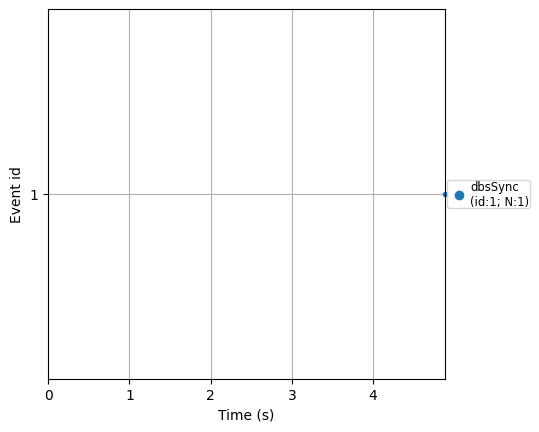

annotation onset in seconds: 4.88350


In [ ]:
# check events
events, event_dict = mne.events_from_annotations(eeg_data)
print(event_dict)
mne.viz.plot_events(events=events, event_id=event_dict, sfreq=eeg_data.info["sfreq"]);

# get the onset of the events
for annotation in eeg_data.annotations:
    print(f"annotation onset in seconds: {annotation['onset']:.5f}")

In [ ]:
# Load DBS
# get file_path from file_info_dbs for sub_id = 'P4-2004'
block_number = 0
dbs_path = [file for file in file_info_dbs if file['sub_id'] == 'P4-2004'][block_number]['file_path']

print(f"Processing {sub_id} from {dbs_path}")

json_data = open_json_file(dbs_path)
dbs_data = read_time_domain_data(json_data, block_number)  #

Processing P4-2004 from /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/RawData/DBS/Report_Json_Session_Report_20241028T163753.json
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 142.0
...length of dbs signal in samples: 35500


### 2. Artifact Detection

EEG

EEG data cropped to 120.0 seconds.


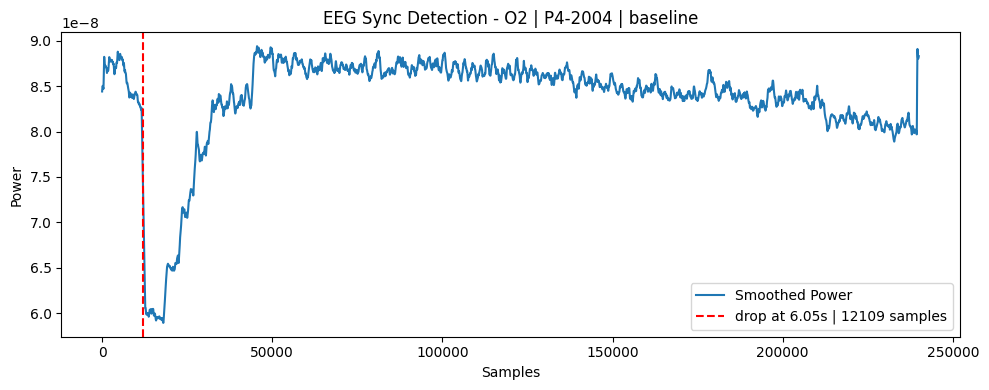

In [ ]:
# EEG
channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=120, freq_high=130, time_range=(0,120), plot=True, save_dir='outputs/outputData', sub_id=sub_id, block=block)

In [ ]:
result

{'sub_id': 'P4-2004',
 'block': 'baseline',
 'type': 'drop',
 'index': 12109,
 'time': 6.0545,
 'magnitude': np.float64(-2.1979669069926454e-08),
 'channel': 'O2',
 'channel_idx': 9,
 'onset_index': np.int64(11606),
 'onset_time': np.float64(5.803)}

In [ ]:
# investigate the artifact

# extract the smoothe_power samples around +- 100 ms around the artifact
eeg_power_artifact = smoothed_power[eeg_sync_idx-1000:eeg_sync_idx+1000]

# plot the artifact_power
fig = go.Figure()

# Add line plot
fig.add_trace(go.Scatter(y=eeg_power_artifact, mode='lines', name='eeg_artifact'))

# Add vertical line at x=125
fig.add_vline(
    x=1000,
    line=dict(color='red', width=2),
    annotation_text="Artifact",
    annotation_position="top right"
)

# Show interactive plot
fig.show()


Artifact is around 1000 samples long (= 0.5s at a sampling rate of 2000)

DBS

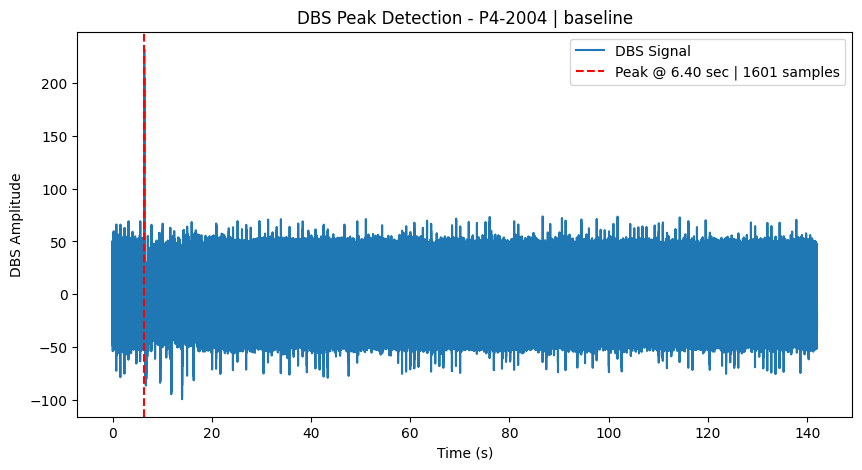

In [ ]:
# Find DBS sync artifact
dbs_signal =  dbs_data["TimeDomainData"].values
dbs_fs = dbs_data["SampleRateInHz"][0]
dbs_peak_idx, dbs_peak_s = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)

In [ ]:
# investigate the artifact
dbs_artifact = dbs_signal[dbs_peak_idx-125:dbs_peak_idx+125]

# Create interactive figure
fig = go.Figure()

# Add line plot
fig.add_trace(go.Scatter(y=dbs_artifact, mode='lines', name='dbs_artifact'))

# Add vertical line at x=125
fig.add_vline(
    x=125,
    line=dict(color='red', width=2),
    annotation_text="Artifact",
    annotation_position="top right"
)

# Show interactive plot
fig.show()

Artifact is around 51 samples long -> 0.25s

### 3. Visually compare the two signals 

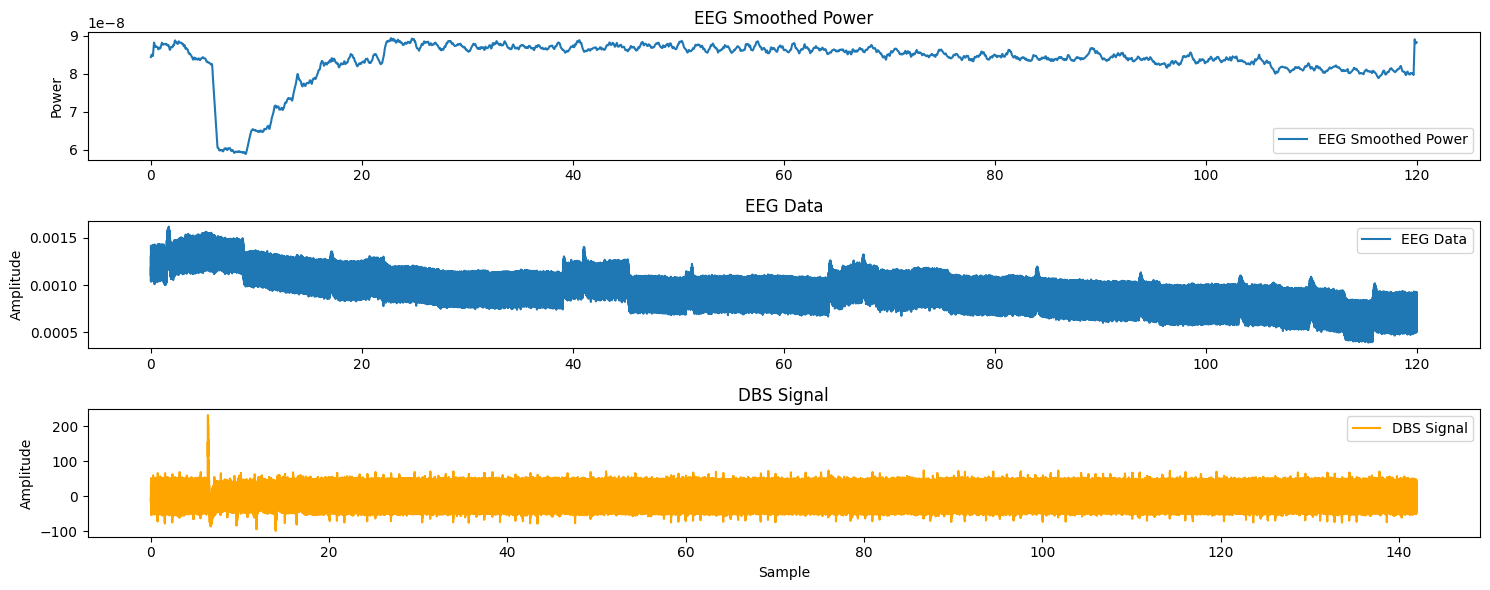

In [ ]:
# Plot EEG smoothed power and DBS signal
plt.figure(figsize=(15, 6))

# to plot on same time axis, convert to seconds
smoothed_power_time = np.arange(len(smoothed_power)) / 2000
dbs_signal_time = np.arange(len(dbs_signal)) / 250

# eeg data: first 120 seconds
eeg_data_cut = eeg_data.get_data()[:, :120*2000]
eeg_data_cut_time = np.arange(len(eeg_data_cut[0])) / 2000

plt.subplot(3, 1, 1)
plt.plot(smoothed_power_time, smoothed_power, label='EEG Smoothed Power')
plt.title('EEG Smoothed Power')
plt.ylabel('Power')
plt.legend()

# plot the eeg data
plt.subplot(3, 1, 2)
plt.plot(eeg_data_cut_time, eeg_data_cut[0], label='EEG Data')
plt.title('EEG Data')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(dbs_signal_time, dbs_signal, label='DBS Signal', color='orange')
plt.title('DBS Signal')
plt.ylabel('Amplitude')
plt.xlabel('Sample')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# length of EEG data
print(f"Shape of EEG data: {eeg_data.get_data().shape}")
# in seconds
print(f"Length of EEG data: {eeg_data.get_data().shape[1] / eeg_data.info['sfreq']} seconds")
# print sample rate
print(f"Sample rate of EEG data: {eeg_data.info['sfreq']} Hz")

# length of DBS data
print(f"Shape of DBS data: {dbs_data['TimeDomainData'].shape}")
# in seconds
print(f"Length of DBS data: {dbs_data['TimeDomainData'].shape[0] / dbs_data['SampleRateInHz'][0]} seconds")
# print sample rate
print(f"Sample rate of DBS data: {dbs_data['SampleRateInHz'][0]} Hz")

Shape of EEG data: (64, 292335)
Length of EEG data: 146.1675 seconds
Sample rate of EEG data: 2000.0 Hz
Shape of DBS data: (35500,)
Length of DBS data: 142.0 seconds
Sample rate of DBS data: 250 Hz


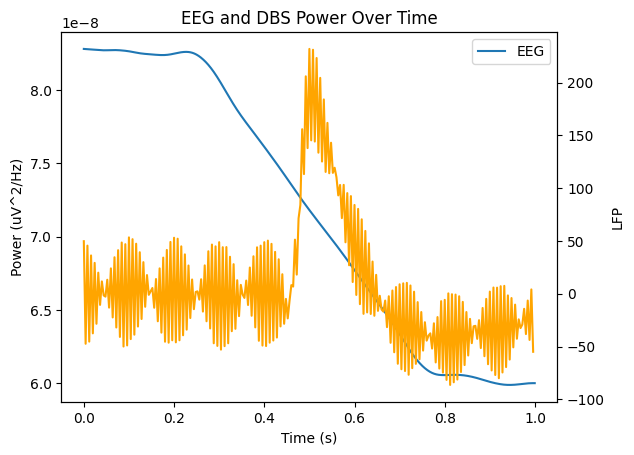

In [ ]:
# overlay the eeg_power_artifact and the dbs_artifact in a plot over time (s)

eeg_times = np.arange(len(eeg_power_artifact)) / 2000
dbs_times = np.arange(len(dbs_artifact)) / 250

# plot the two artifacts
plt.plot(eeg_times, eeg_power_artifact)
plt.ylabel('Power (uV^2/Hz)')
plt.xlabel('Time (s)')
plt.title('EEG and DBS Power Over Time')
plt.legend(['EEG'])
# y-axis for dbs on the right
plt.twinx()
plt.plot(dbs_times, dbs_artifact, color='orange')
plt.ylabel('LFP')

plt.show()

### 4. Cut data at sync index

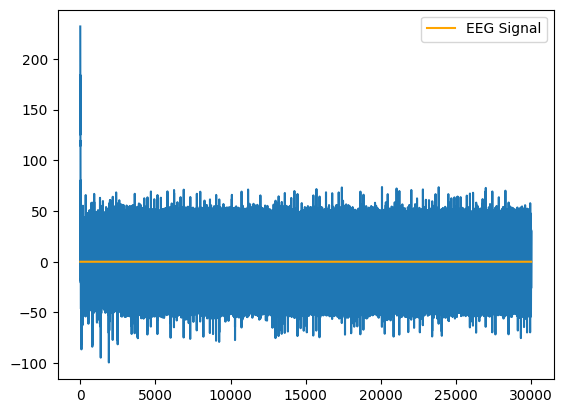

In [ ]:
# cut the dbs signal at the dbs_peak_idx to two minutes

duration = 120
dbs_signal_cut = dbs_signal[dbs_peak_idx:(dbs_peak_idx+250*duration)]

# cut the eeg signal at the eeg_sync_idx
eeg_signal_cut = eeg_data.copy().crop(tmin=eeg_sync_s, tmax=eeg_sync_s+duration)

# plot the two cut signals
# downsample the eeg signal to 250 Hz
eeg_signal_cut_downsampled = eeg_signal_cut.copy().resample(250)

plt.plot(dbs_signal_cut)
plt.plot(eeg_signal_cut_downsampled.get_data()[9], color='orange', label='EEG Signal')
plt.legend()
plt.show()

In [ ]:
# save the two cut signals (numpy.ndarray) as csv
np.savetxt(f"eeg_signal_cut_downsampled_{sub_id}.csv", eeg_signal_cut_downsampled.get_data()[9], delimiter=",")
np.savetxt(f"dbs_signal_cut_{sub_id}.csv", dbs_signal_cut, delimiter=",")

ToDo: plot with 2 different scales (right y-axis: dbs, left y-axis: eeg)

## 3. Correlation metrics and coherence

random sample vs aligned recordings

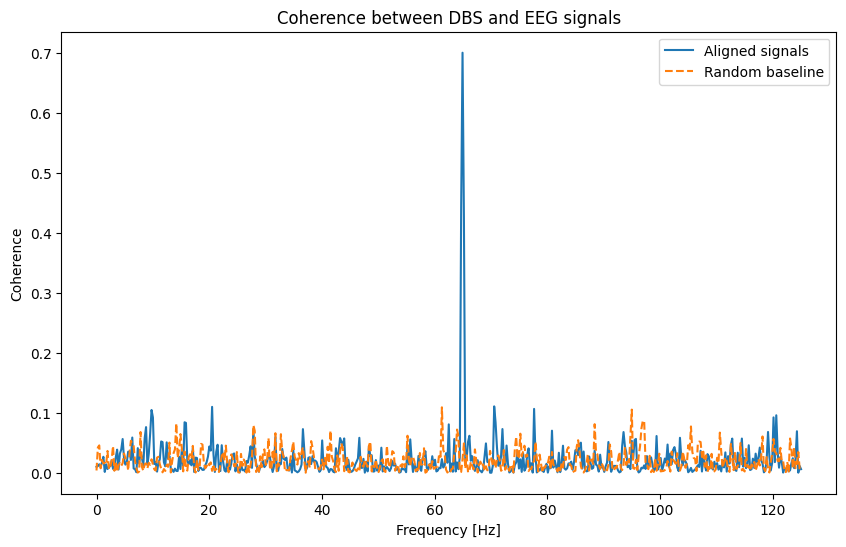

(np.float64(-0.0014683332008642116),
 np.float64(0.010045312058310886),
 np.int64(1938))

In [ ]:
from scipy.signal import coherence, correlate
from scipy.stats import pearsonr

# get Cz channel from eeg_signal_cut_downsampled 
cz_idx = eeg_signal_cut_downsampled.ch_names.index('Cz')

eeg_signal_final = eeg_signal_cut_downsampled.get_data()[cz_idx]

# Ensure equal length
min_len = min(len(dbs_signal_cut), len(eeg_signal_final))
dbs_signal_cut = dbs_signal_cut[:min_len]
eeg_signal_final = eeg_signal_final[:min_len]

# Example 1: Pearson correlation
pearson_corr, _ = pearsonr(dbs_signal_cut, eeg_signal_final)

# Example 2: Cross-correlation (to check for lag)
cross_corr = correlate(dbs_signal_cut - np.mean(dbs_signal_cut),
                       eeg_signal_final - np.mean(eeg_signal_final),
                       mode='full')
lags = np.arange(-len(dbs_signal_cut) + 1, len(dbs_signal_cut))
lag_at_max = lags[np.argmax(cross_corr)]

# Example 3: Coherence (frequency domain similarity)
f, Cxy = coherence(dbs_signal_cut, eeg_signal_final, fs=250, nperseg=1024)

# Generate random baseline by shuffling EEG signal
np.random.seed(42)
eeg_random = np.random.permutation(eeg_signal_final)

# Baseline metrics
pearson_corr_random, _ = pearsonr(dbs_signal_cut, eeg_random)
f_random, Cxy_random = coherence(dbs_signal_cut, eeg_random, fs=250, nperseg=1024)

# Plot coherence comparison
plt.figure(figsize=(10, 6))
plt.plot(f, Cxy, label='Aligned signals')
plt.plot(f_random, Cxy_random, label='Random baseline', linestyle='--')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Coherence')
plt.title('Coherence between DBS and EEG signals')
plt.legend()
plt.show()

pearson_corr, pearson_corr_random, lag_at_max

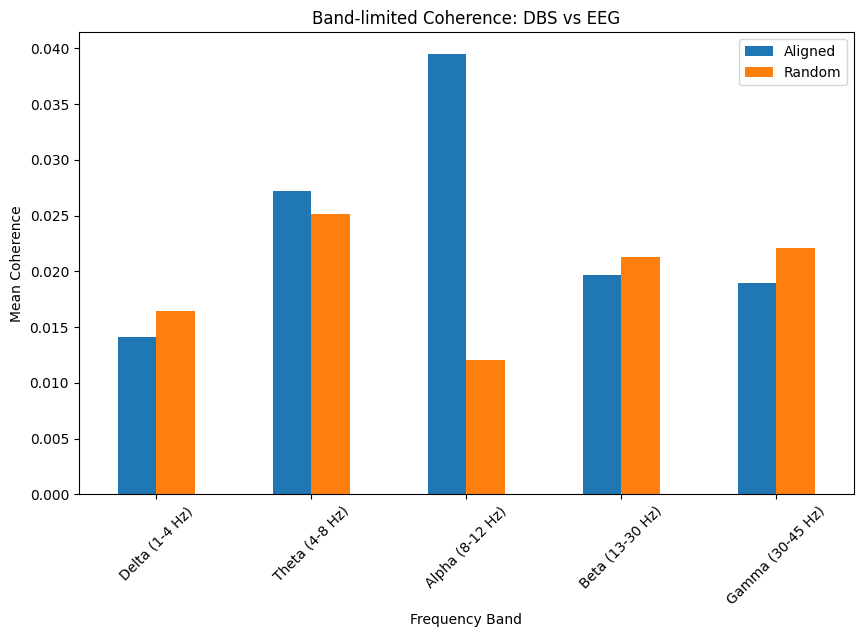

,Aligned,Random
Delta (1-4 Hz),0.014084,0.016404
Theta (4-8 Hz),0.027193,0.025104
Alpha (8-12 Hz),0.039467,0.012068
Beta (13-30 Hz),0.019676,0.021274
Gamma (30-45 Hz),0.018988,0.022116


In [ ]:
# Define frequency bands of interest
bands = {
    "Delta (1-4 Hz)": (1, 4),
    "Theta (4-8 Hz)": (4, 8),
    "Alpha (8-12 Hz)": (8, 12),
    "Beta (13-30 Hz)": (13, 30),
    "Gamma (30-45 Hz)": (30, 45)
}

band_results = {}

# Compute mean coherence for each band
for band, (fmin, fmax) in bands.items():
    band_mask = (f >= fmin) & (f <= fmax)
    mean_coh = np.mean(Cxy[band_mask])
    mean_coh_random = np.mean(Cxy_random[band_mask])
    band_results[band] = {
        "Aligned": mean_coh,
        "Random": mean_coh_random
    }

# Convert to DataFrame for easier visualization
band_df = pd.DataFrame(band_results).T

# Plot results
band_df.plot(kind="bar", figsize=(10,6))
plt.title("Band-limited Coherence: DBS vs EEG")
plt.ylabel("Mean Coherence")
plt.xlabel("Frequency Band")
plt.xticks(rotation=45)
plt.show()

band_df

--> no good results

Cross-Correlation Peak Near Zero (Sanity Check): a local maximum near lag 0 in the cross-correlation function indicates the alignment is likely consistent.

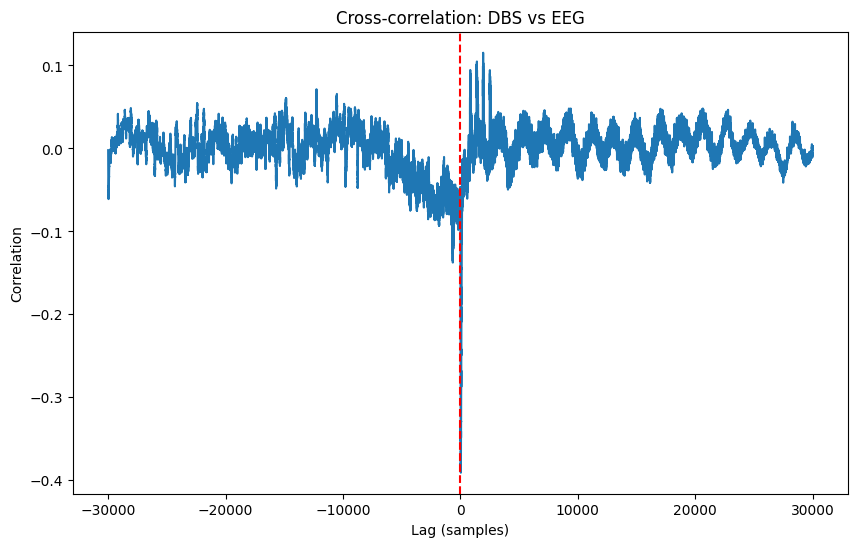

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(lags, cross_corr)
plt.axvline(0, color='red', linestyle='--')
plt.title("Cross-correlation: DBS vs EEG")
plt.xlabel("Lag (samples)")
plt.ylabel("Correlation")
plt.show()

No good results

# Loop over participants and create the sync overlay plot for all of them

In [ ]:
result

{'sub_id': 'P4-2001',
 'block': 'baseline',
 'type': 'spike',
 'index': 37050,
 'time': 18.525,
 'magnitude': np.float64(5.087065906453986e-08),
 'channel': 'O2',
 'channel_idx': 9,
 'onset_index': np.int64(36516),
 'onset_time': np.float64(18.258)}

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2001/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 184.0
...length of dbs signal in samples: 46000
EEG data cropped to 120.0 seconds.


<Figure size 1200x600 with 0 Axes>

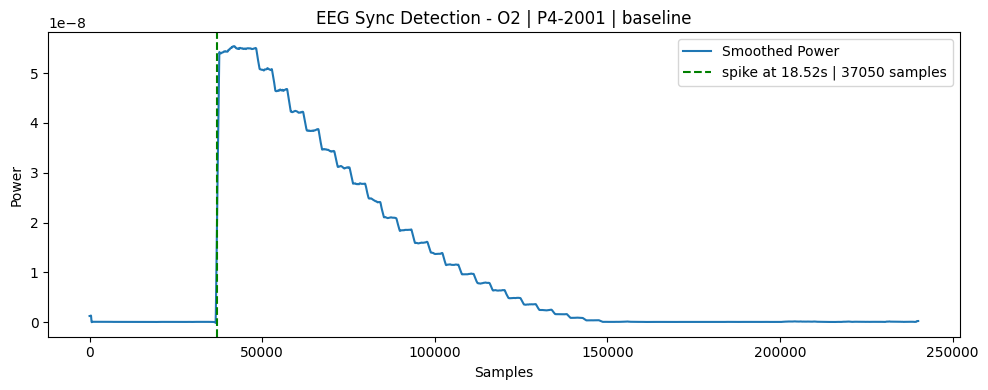

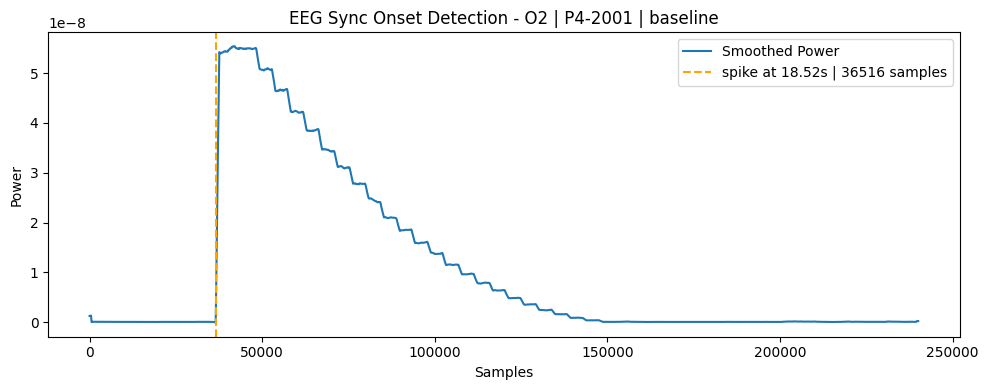

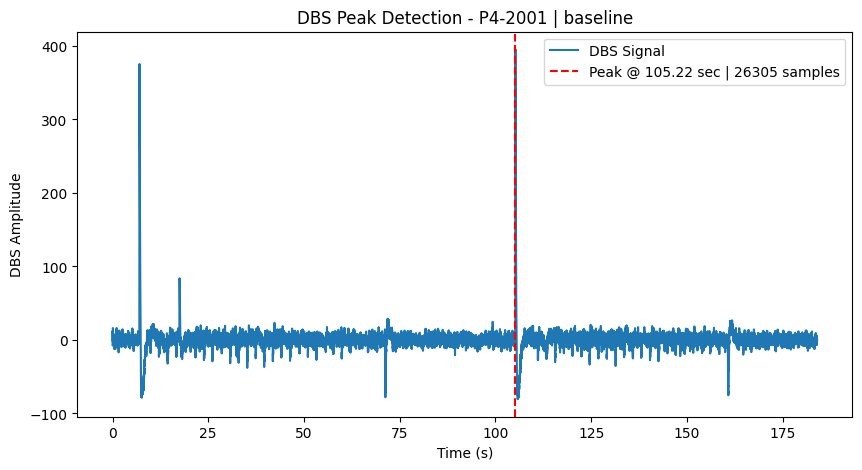

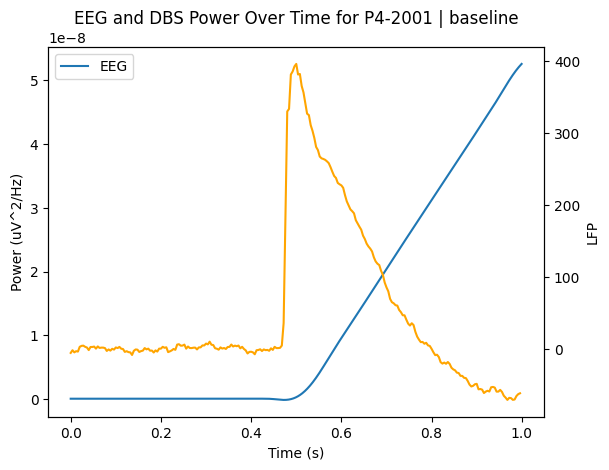

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2002/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 159.252
...length of dbs signal in samples: 39813
EEG data cropped to 120.0 seconds.


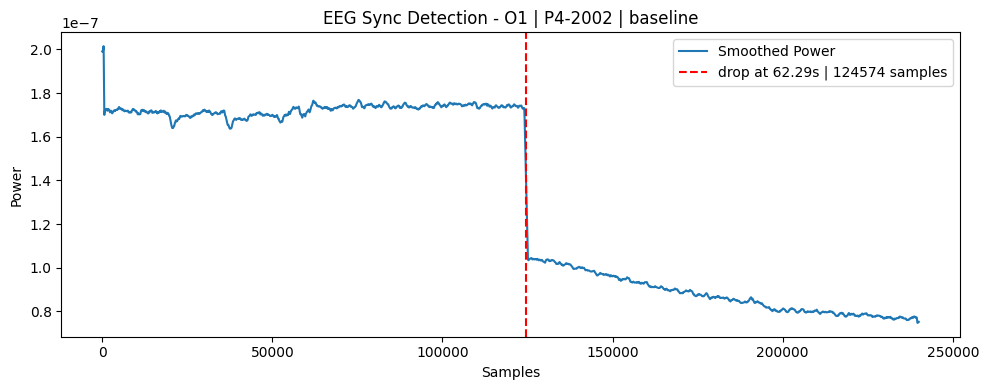

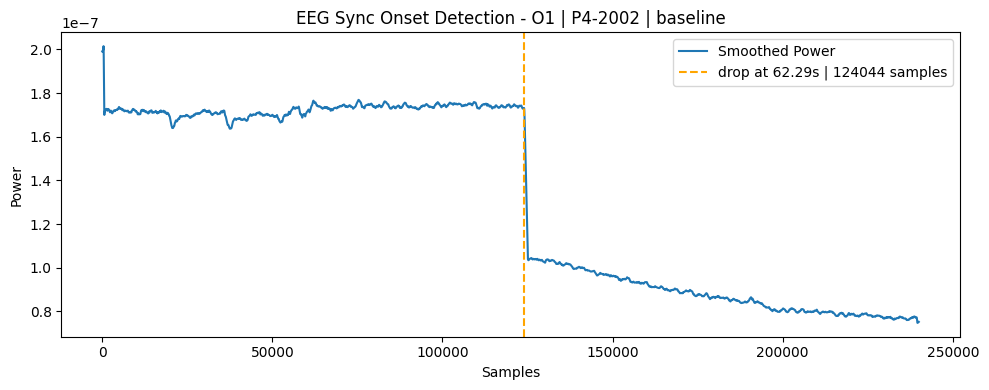

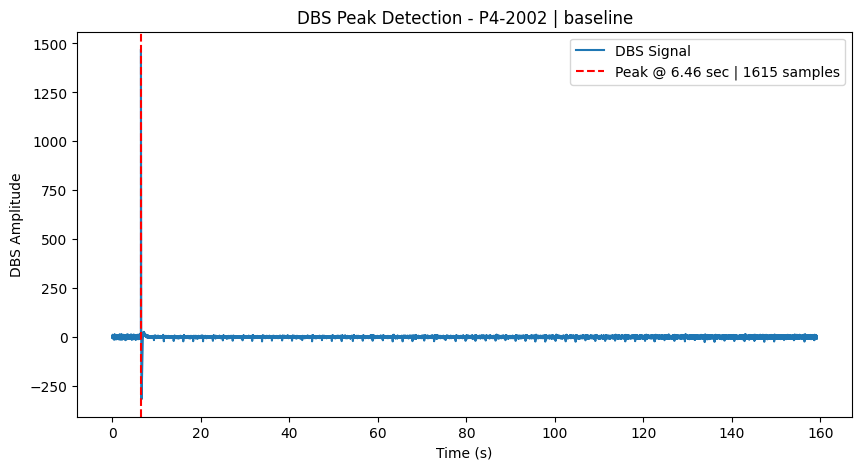

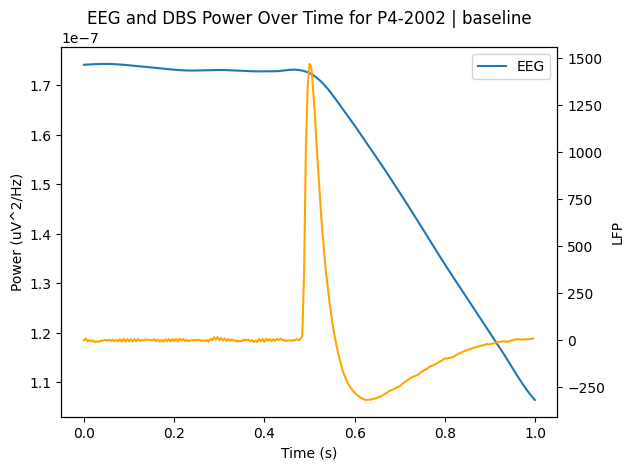

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2003/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 138.5
...length of dbs signal in samples: 34625
EEG data cropped to 120.0 seconds.


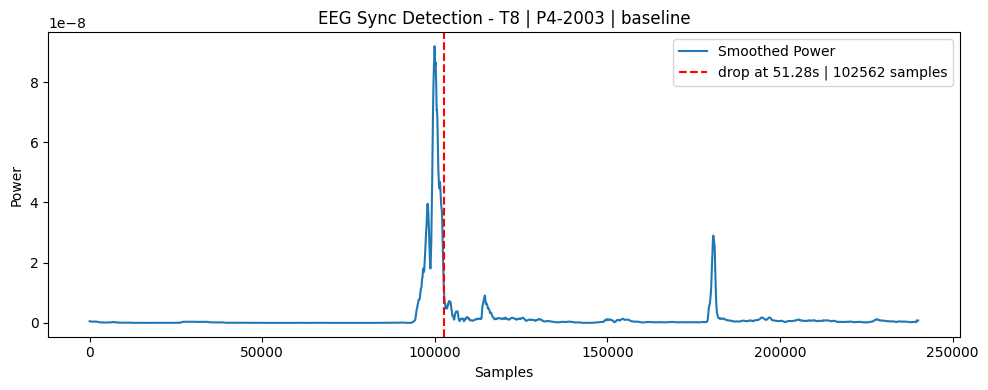

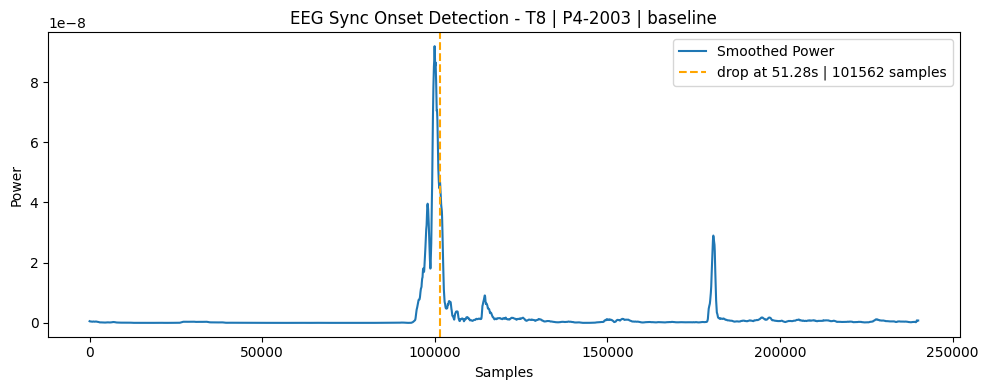

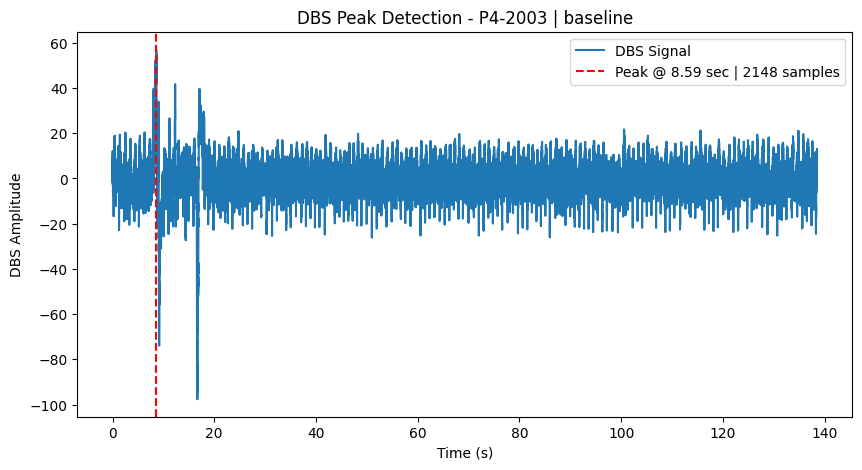

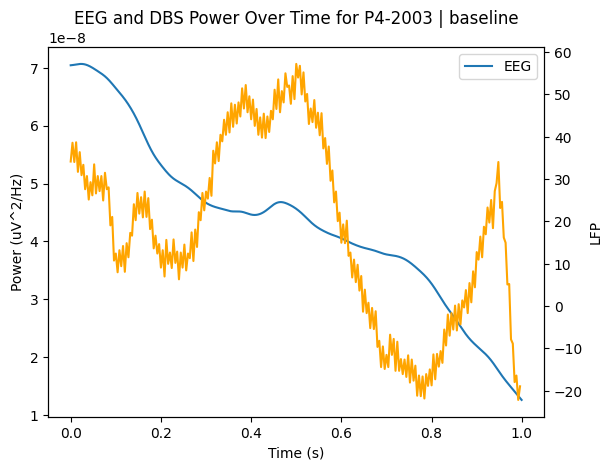

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2004/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 142.0
...length of dbs signal in samples: 35500
EEG data cropped to 120.0 seconds.


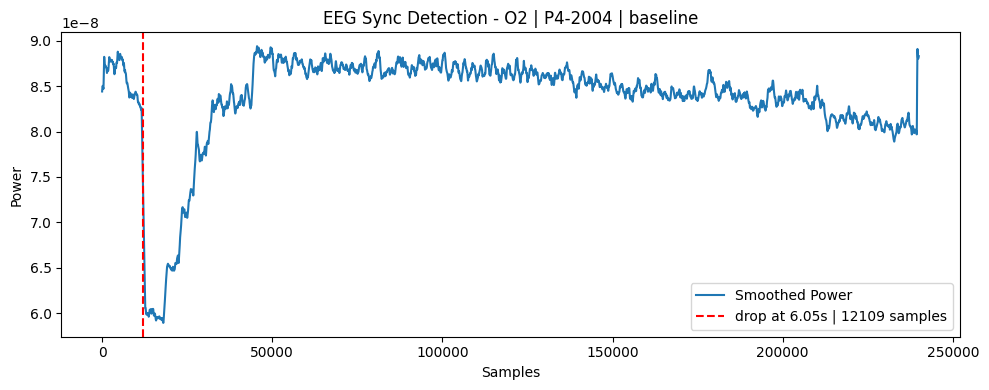

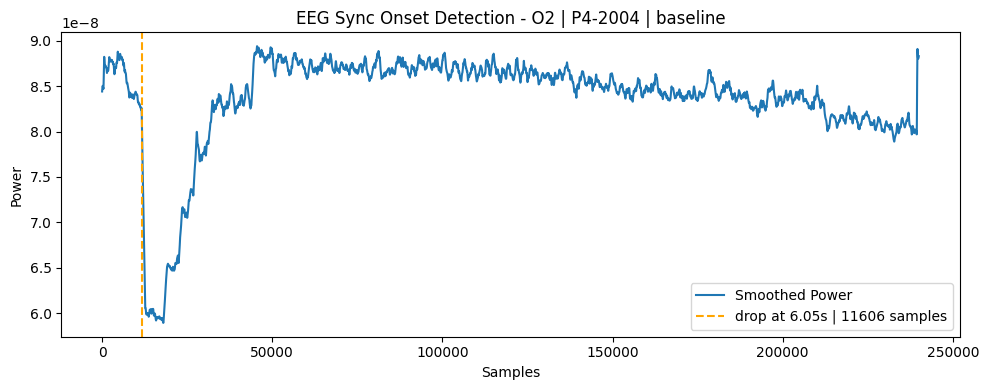

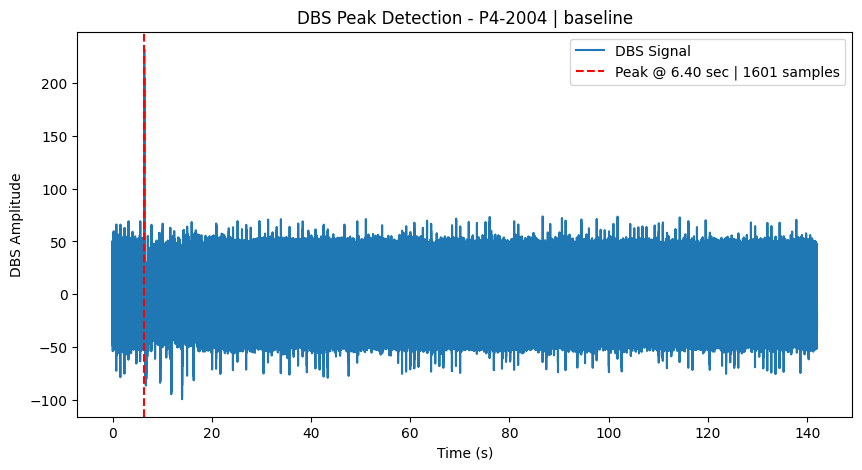

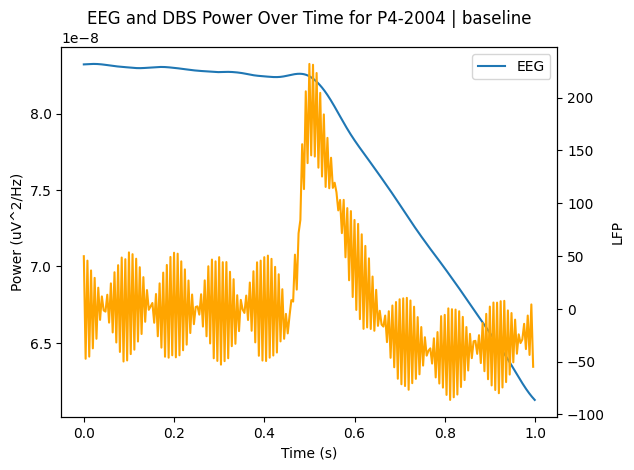

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2005/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 209.0
...length of dbs signal in samples: 52250
EEG data cropped to 120.0 seconds.


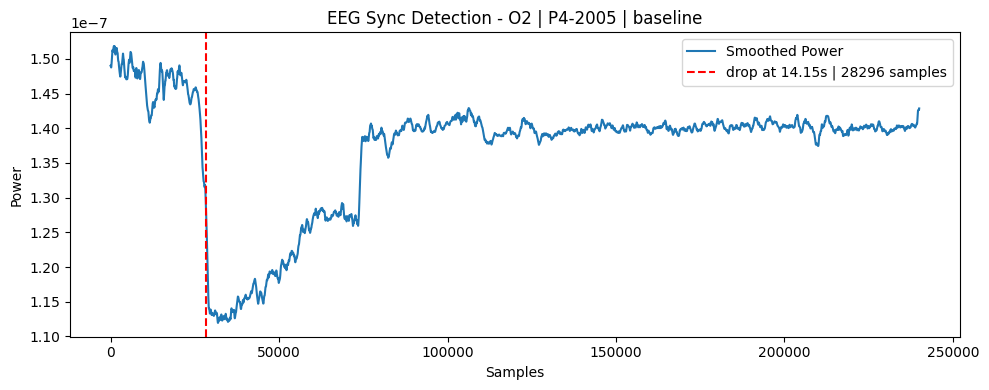

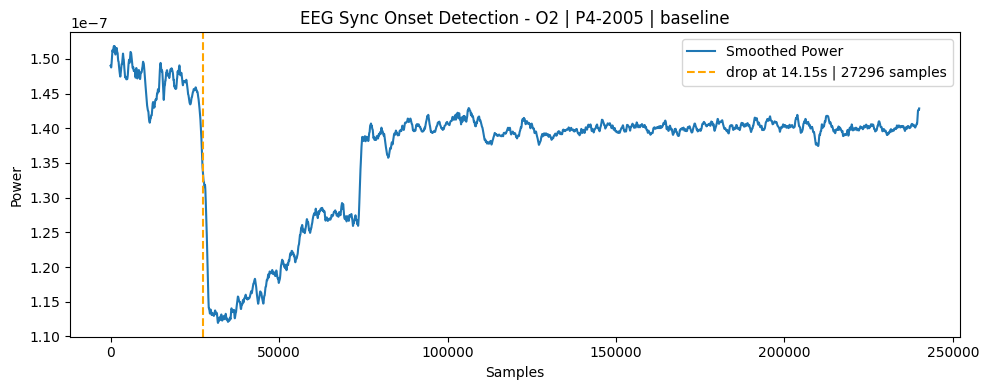

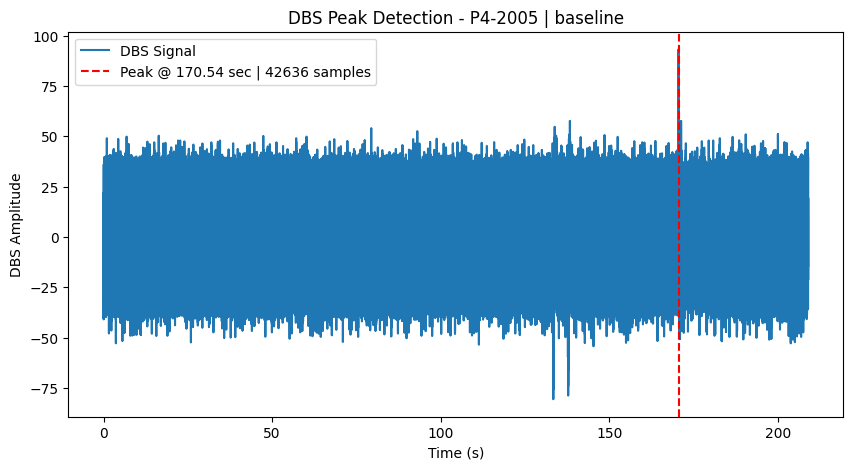

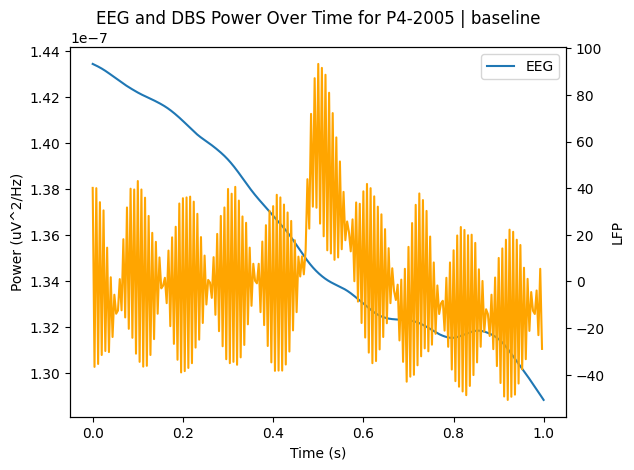

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2007/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 136.5
...length of dbs signal in samples: 34125
EEG data cropped to 120.0 seconds.


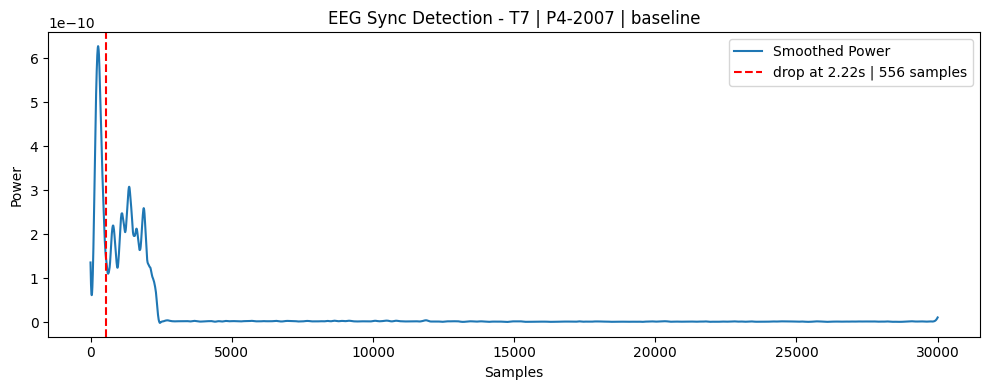

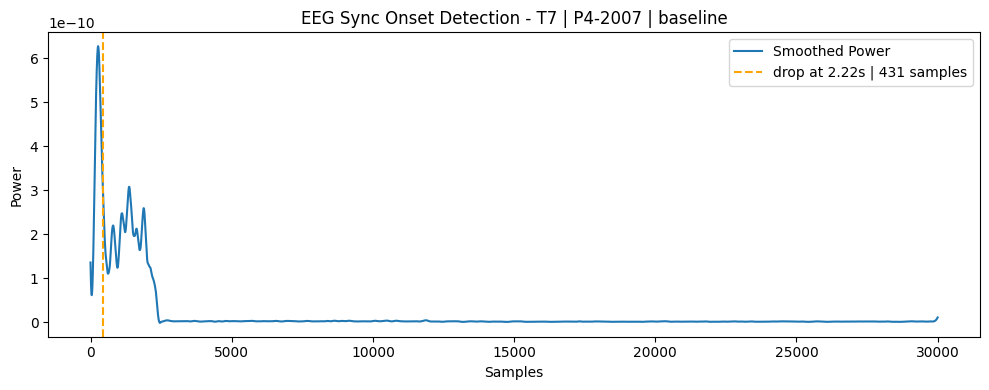

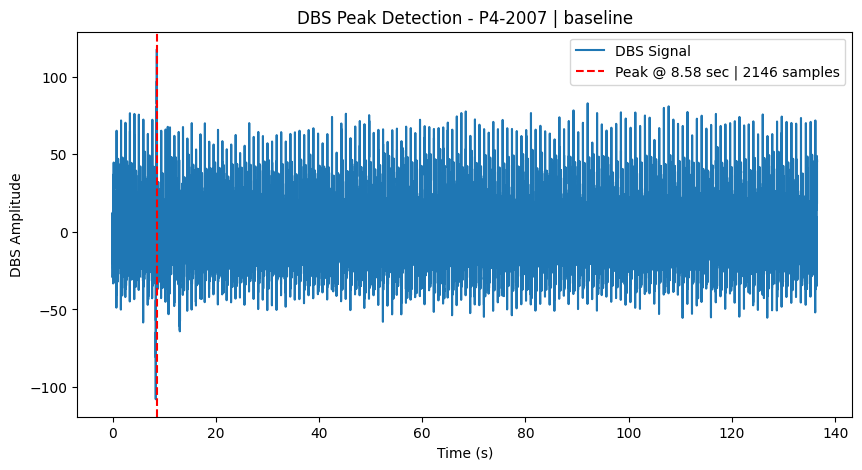

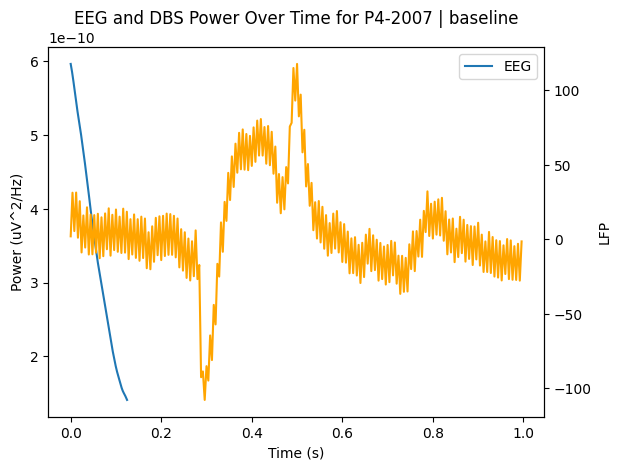

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2008/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 153.0
...length of dbs signal in samples: 38250
EEG data cropped to 120.0 seconds.


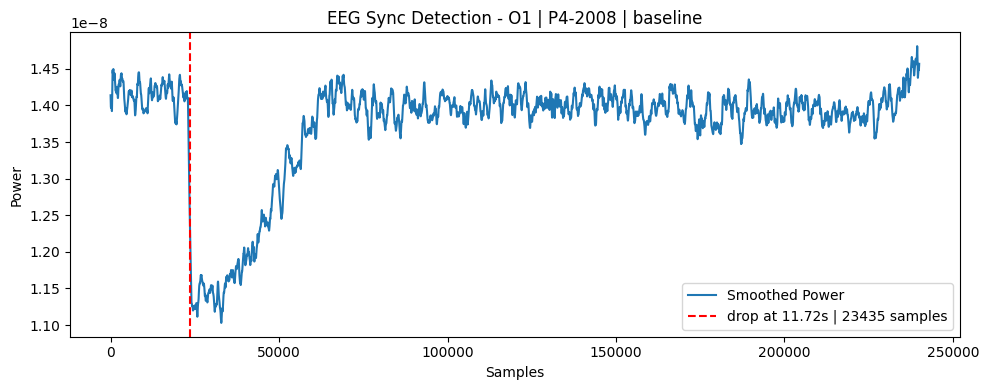

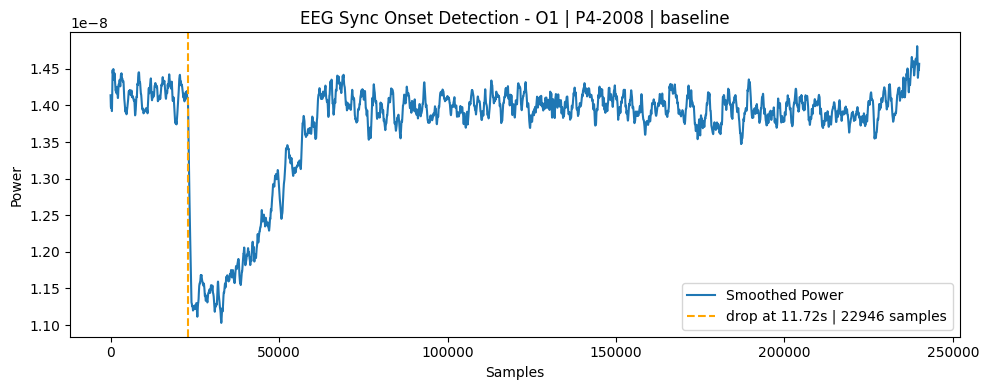

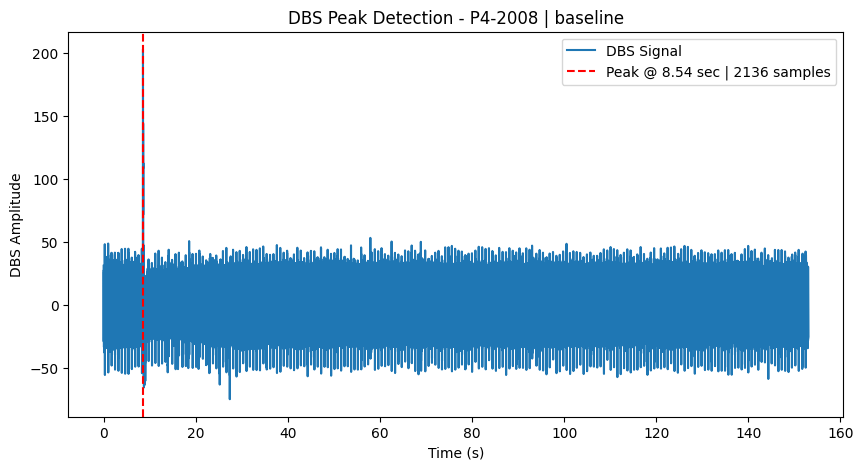

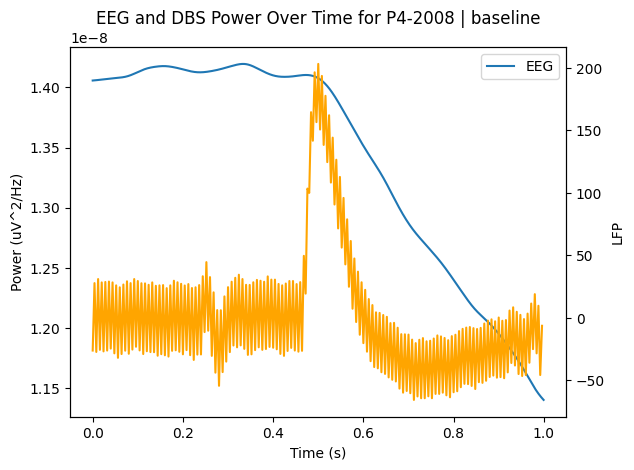

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2009/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 60.0
...length of dbs signal in samples: 15000
EEG data cropped to 120.0 seconds.


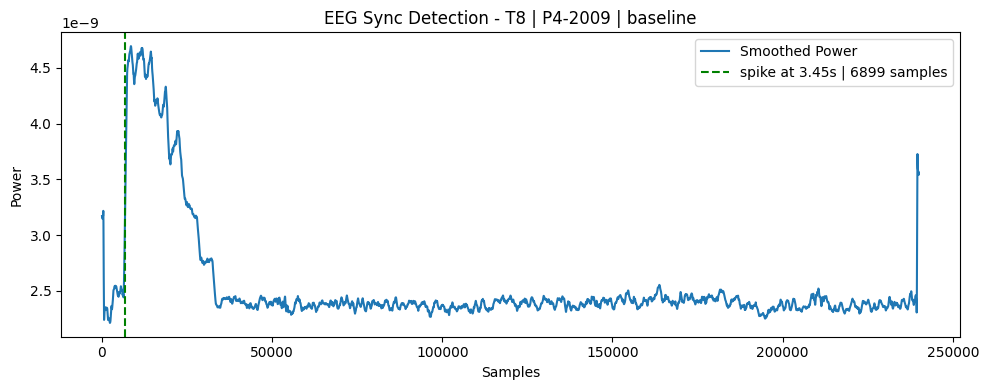

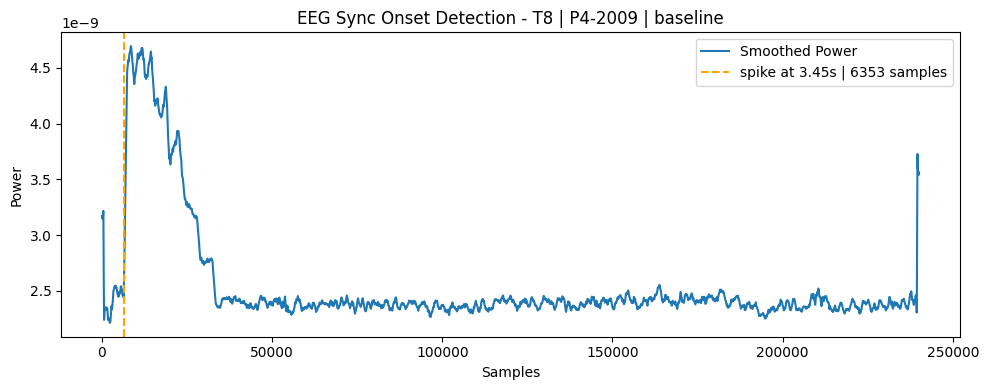

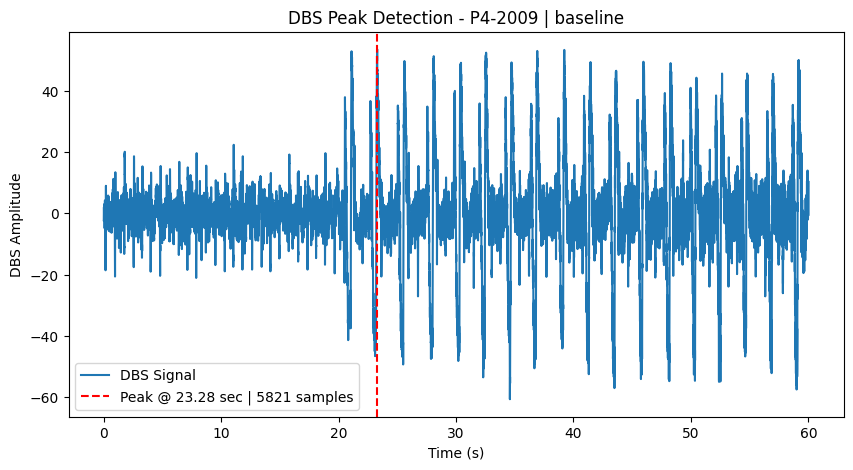

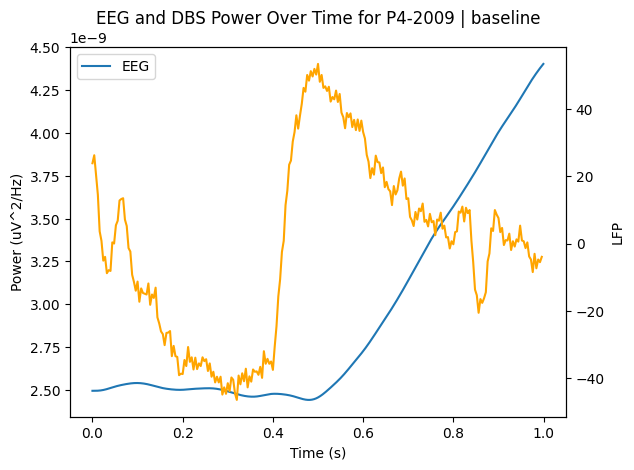

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2010/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 451.5
...length of dbs signal in samples: 112875
EEG data cropped to 120.0 seconds.


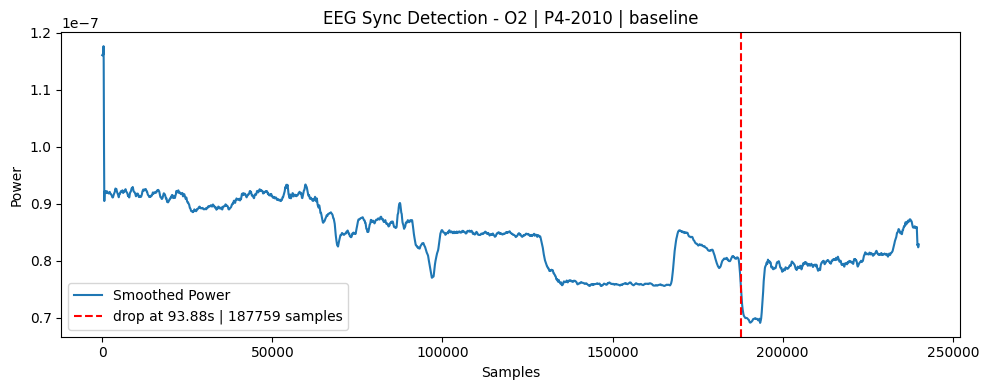

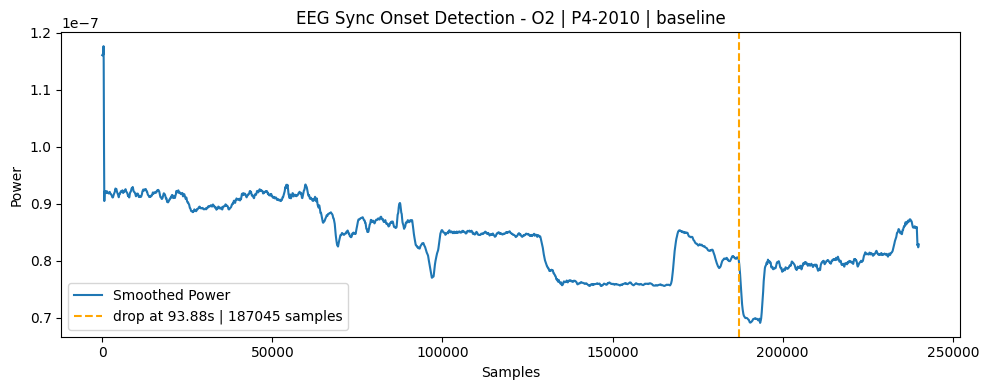

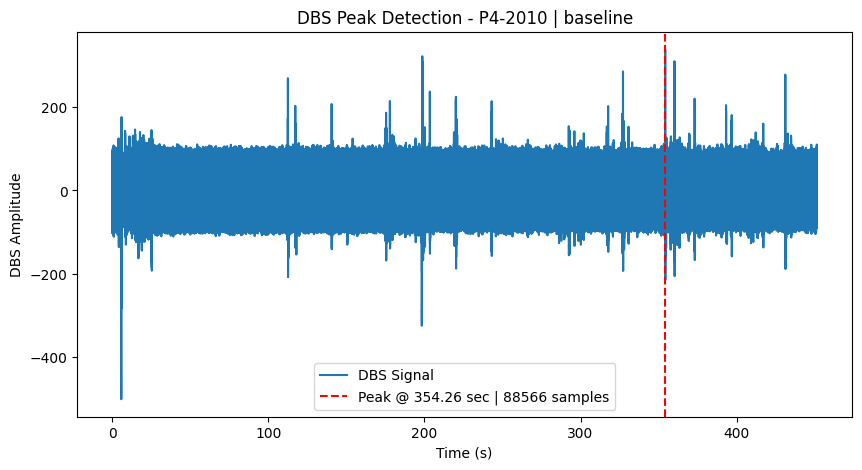

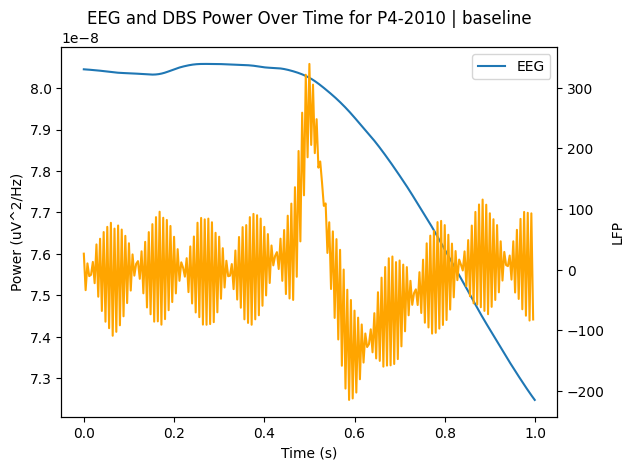

---
Successfully loaded /Volumes/03_Neurofeedback/project_only/02_Data/Patient_NFB/P4-2011/ProcessedData/EEG/baseline/baseline_prep.set
---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 164.0
...length of dbs signal in samples: 41000
EEG data cropped to 120.0 seconds.


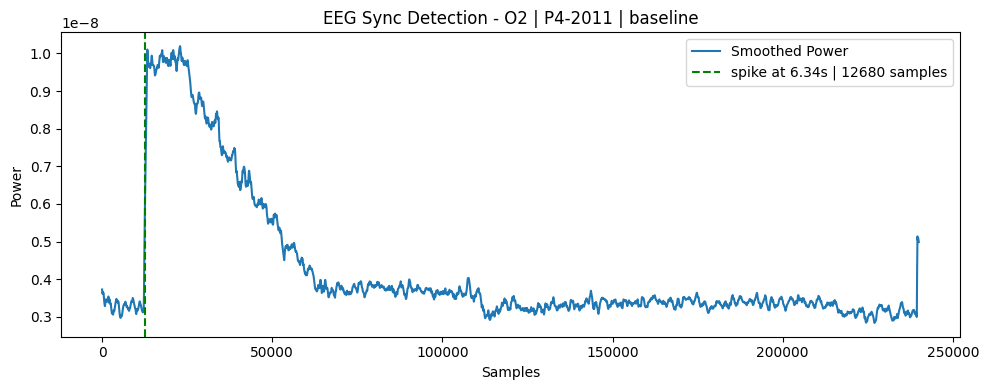

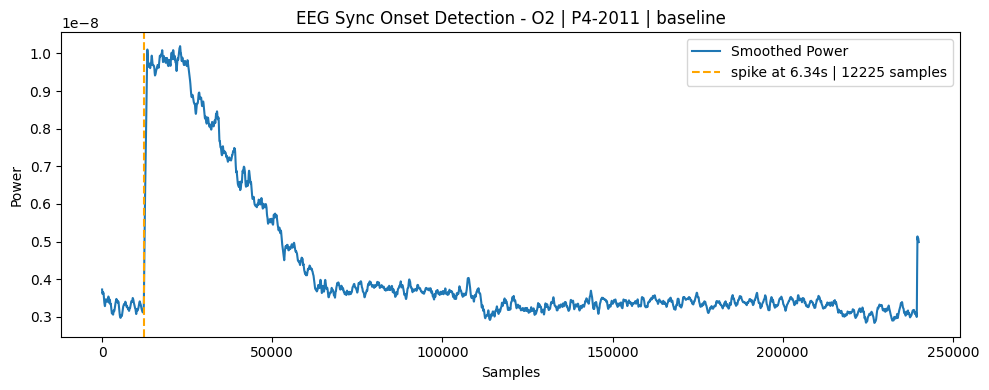

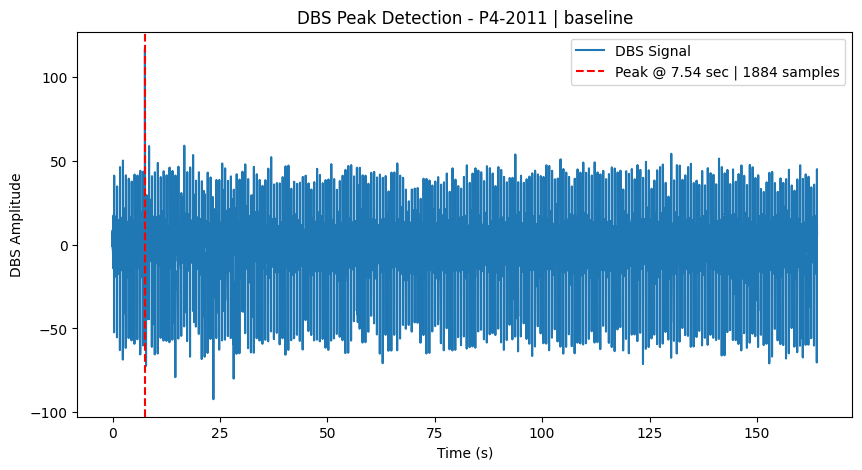

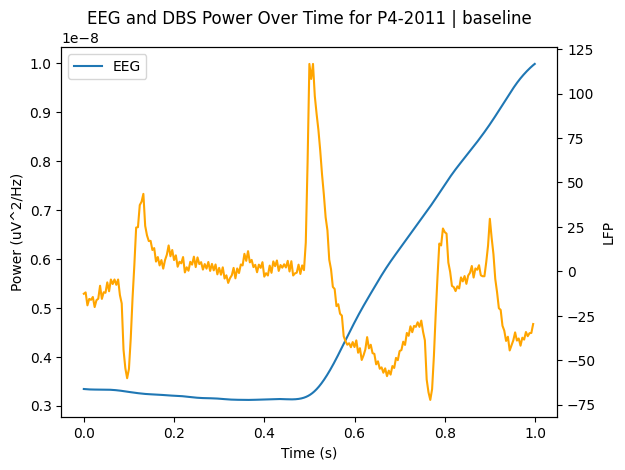

In [ ]:
# Initialize figure
plt.figure(figsize=(12, 6))

for sub_id in sub_ids:
    # load the eeg and dbs data
    eeg_file = os.path.join(dataDir_server, sub_id, 'ProcessedData', 'EEG', block, block + '_prep.set')
    eeg_data, sfreq = load_eeg_data(eeg_file)

    # Load DBS
    # get file_path from file_info_dbs for sub_id = 'P4-2004'
    if block == 'baseline':
        block_number = 0
    # add block indexing later
    dbs_path = [file for file in file_info_dbs if file['sub_id'] == sub_id][block_number]['file_path']

    json_data = open_json_file(dbs_path)
    dbs_data = read_time_domain_data(json_data, block_number) 

    # EEG
    if sub_id == 'P4-2007':
        channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=110, freq_high=120, time_range=(0,120), plot=True, save_dir=None, sub_id=sub_id, block=block)
    else:
        channel, eeg_sync_idx, eeg_sync_s, result, smoothed_power = detect_sync_from_eeg(eeg_data, freq_low=120, freq_high=130, time_range=(0,120), plot=True, save_dir=None, sub_id=sub_id, block=block)

    # also plot the detected onset of the artifact
    plt.figure(figsize=(10, 4))
    plt.plot(smoothed_power, label="Smoothed Power")
    plt.axvline(result["onset_index"], color="orange" if result["type"] == "drop" else "orange",
                linestyle="--", label=f"{result['type']} at {result['time']:.2f}s | {result['onset_index']} samples")
    plt.title(f"EEG Sync Onset Detection - {channel} | {result['sub_id']} | {result['block']}")
    plt.xlabel("Samples")
    plt.ylabel("Power")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # test eeg_onset_idx and eeg_sync_idx
    eeg_sync_idx = result["onset_index"]
    eeg_sync_s = result["onset_time"]

    # extract the smoothe_power samples around +- 0.5s around the artifact
    eeg_power_artifact = smoothed_power[eeg_sync_idx-int(eeg_data.info['sfreq']/2):eeg_sync_idx+int(eeg_data.info['sfreq']/2)]
    eeg_times = np.arange(len(eeg_power_artifact)) / eeg_data.info['sfreq']

    # Find DBS sync artifact
    dbs_signal =  dbs_data["TimeDomainData"].values
    dbs_fs = dbs_data["SampleRateInHz"][0]
    dbs_peak_idx, dbs_peak_s = find_dbs_peak(dbs_signal, dbs_fs, save_dir=None, sub_id=sub_id, block=block)
    # investigate the artifact
    dbs_artifact = dbs_signal[dbs_peak_idx-int(dbs_fs/2):dbs_peak_idx+int(dbs_fs/2)]
    dbs_times = np.arange(len(dbs_artifact)) / dbs_fs

    # overlay the eeg_power_artifact and the dbs_artifact in a plot over time (s)
    # plot the two artifacts
    plt.plot(eeg_times, eeg_power_artifact)
    plt.ylabel('Power (uV^2/Hz)')
    plt.xlabel('Time (s)')
    plt.title(f'EEG and DBS Power Over Time for {sub_id} | {block}')
    plt.legend(['EEG'])
    # y-axis for dbs on the right
    plt.twinx()
    plt.plot(dbs_times, dbs_artifact, color='orange')
    plt.ylabel('LFP')

    plt.show()

    